In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import initdirs

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
import networkx as nx
from glob import glob
import nxpd
import os

nxpd.nxpdParams['show'] = 'ipynb'

In [4]:
from epypes import compgraph

from visioncg import cbcalib
from visioncg.io import open_image, sorted_glob

In [5]:
cg_stereocalib = cbcalib.CGCalibrateStereo()

In [6]:
imfiles1 = sorted_glob(os.path.join(initdirs.DATA_DIR, 'opencv_cb_left/*.jpg'))
imfiles2 = sorted_glob(os.path.join(initdirs.DATA_DIR, 'opencv_cb_right/*.jpg'))
images1 = [open_image(f, cv2.IMREAD_GRAYSCALE) for f in imfiles1]
images2 = [open_image(f, cv2.IMREAD_GRAYSCALE) for f in imfiles2]

psize = (9, 6)
sq_size = 10.

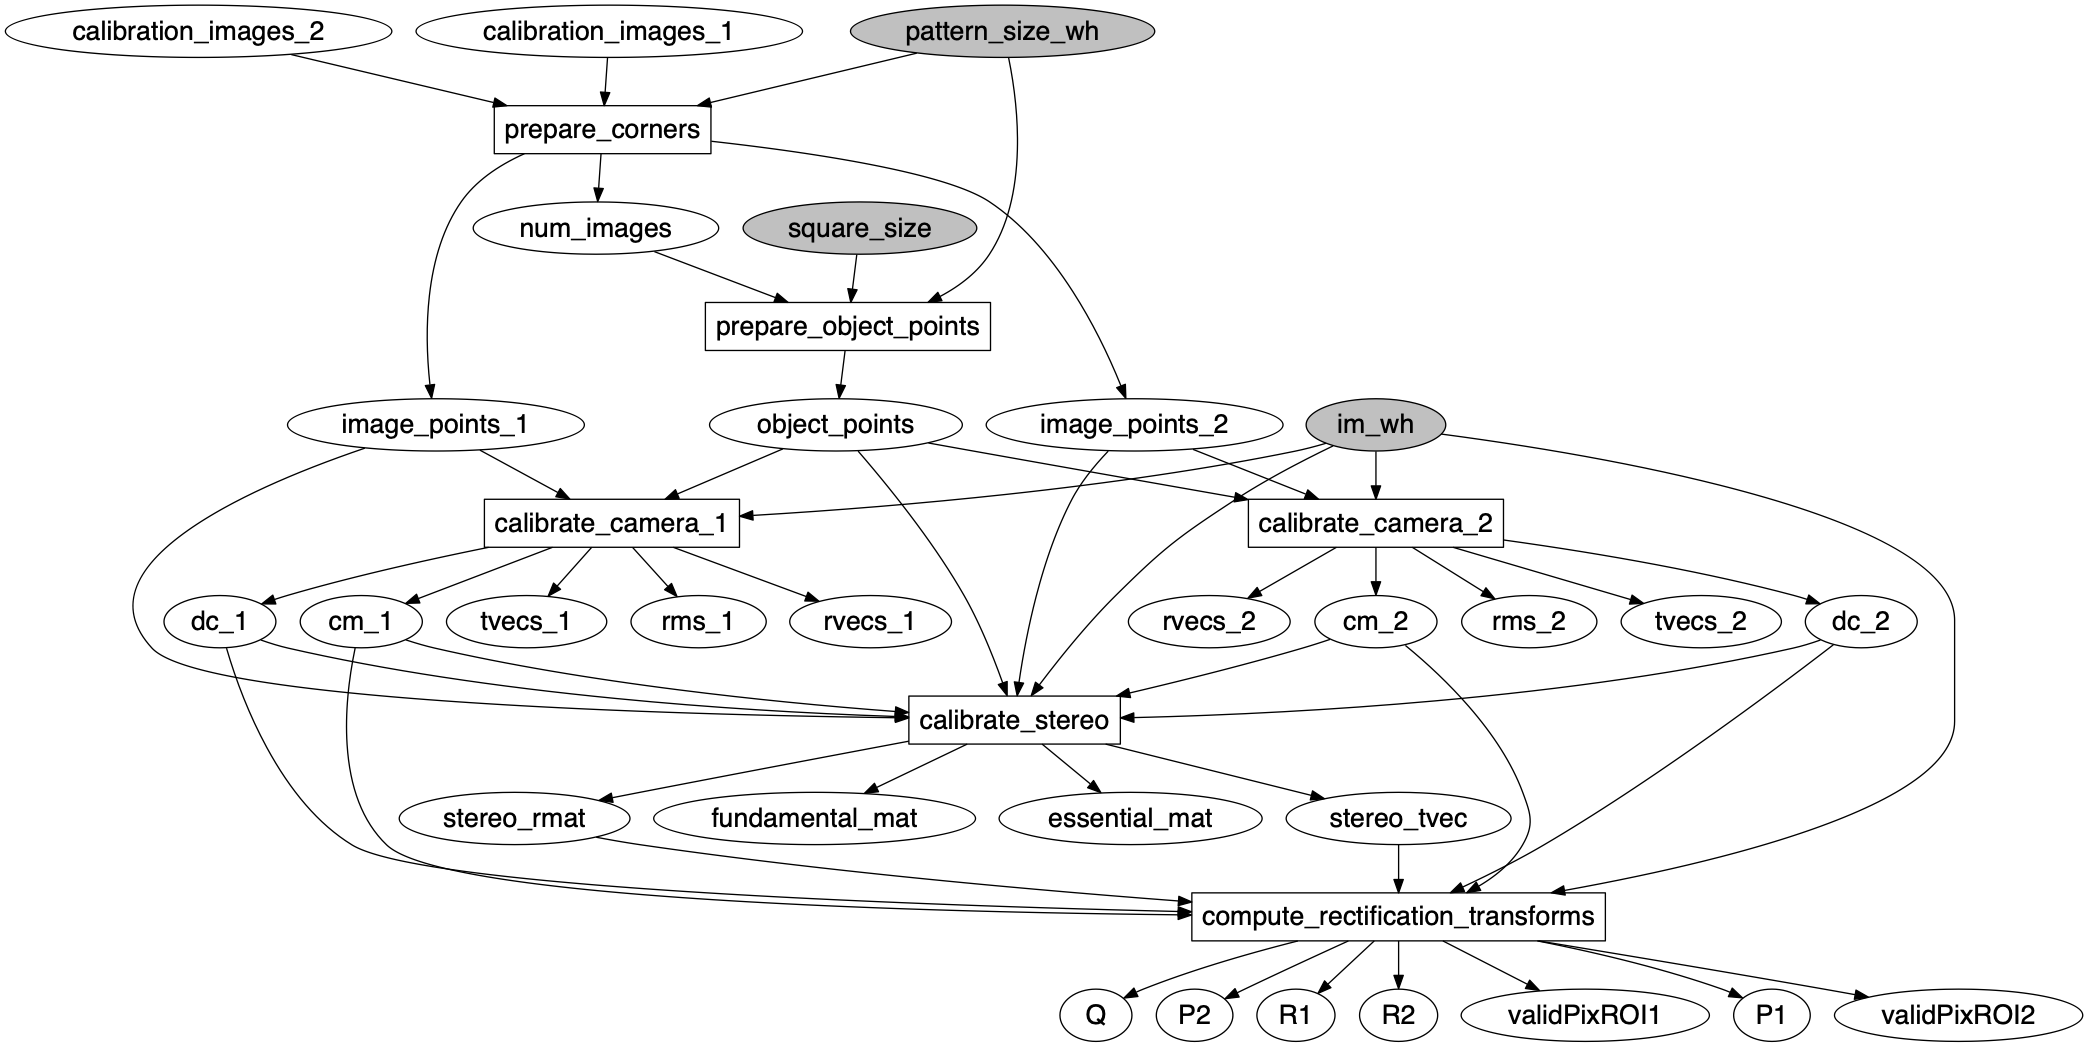

In [7]:
params = {
    'im_wh': cbcalib.get_im_wh(images1[0]),
    'pattern_size_wh': psize,
    'square_size': sq_size   
}

runner = compgraph.CompGraphRunner(cg_stereocalib, frozen_tokens=params)

nxg = runner.token_manager.to_networkx()
for node_name in nxg.nodes():
    nxg.node[node_name]['fontname'] = 'Helvetica'
    nxg.node[node_name]['fontsize'] = 20

nxpd.draw(nxg)

In [8]:
runner.run(calibration_images_1=images1, calibration_images_2=images2)

In [9]:
print('Number of calibration images opened: ', len(runner['calibration_images_1']))
print('Number of images with good corners', len(runner['image_points_1']))

Number of calibration images opened:  13
Number of images with good corners 13


## Chessboard corners on the original images

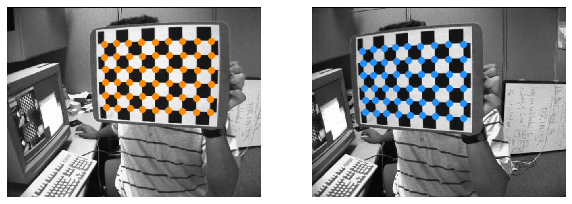

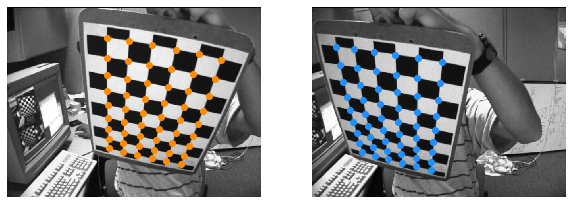

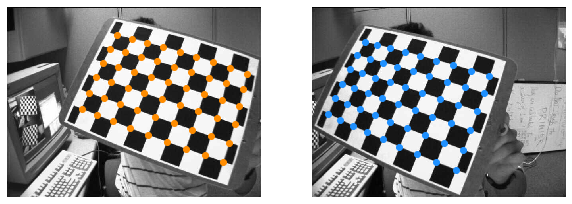

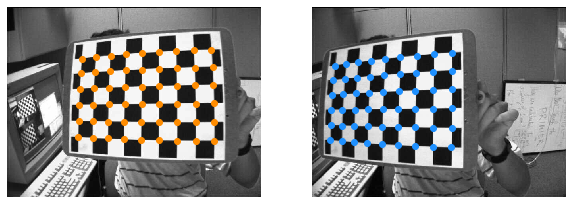

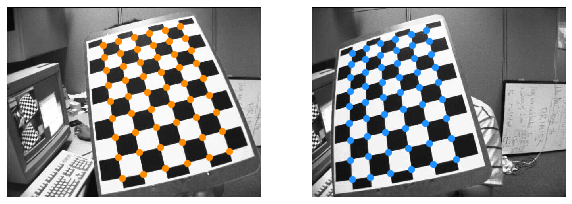

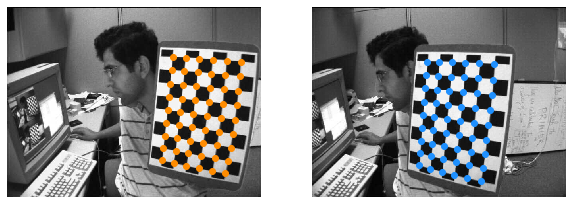

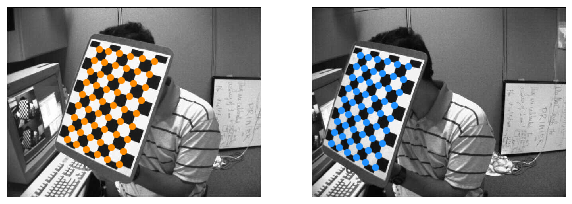

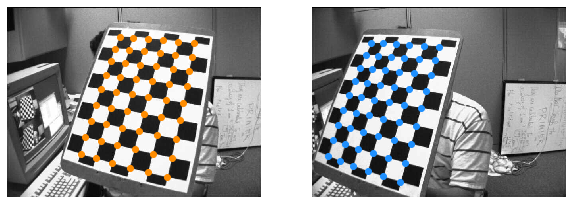

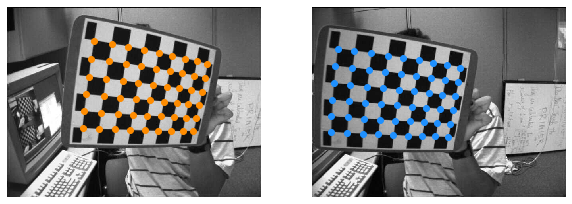

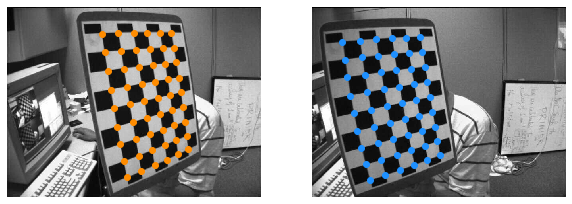

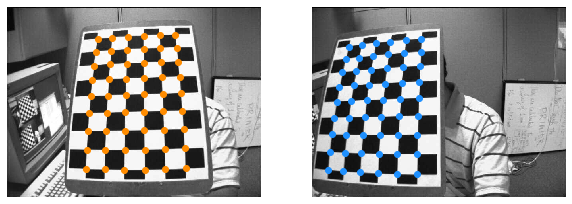

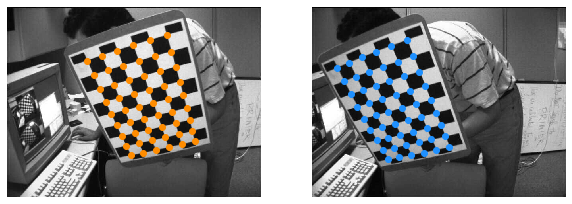

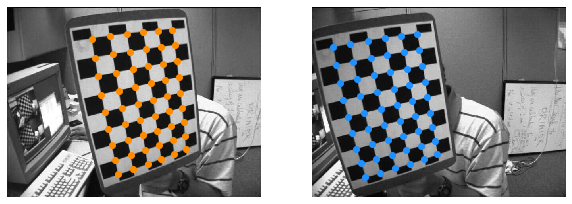

In [10]:
n_images = len(images1)

assert len(runner['image_points_1']) == len(runner['image_points_2']) == n_images

for i in range(n_images):
    
    im1 = images1[i]
    im2 = images2[i]
    
    points_1 = runner['image_points_1'][i]
    points_2 = runner['image_points_2'][i]
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(im1, cmap='gray')
    plt.axis('off')
    plt.scatter(points_1[:, 0], points_1[:, 1], color='darkorange')
    
    plt.subplot(1, 2, 2)
    plt.imshow(im2, cmap='gray')
    plt.axis('off')
    plt.scatter(points_2[:, 0], points_2[:, 1], color='dodgerblue')

## Undistortion of the original images

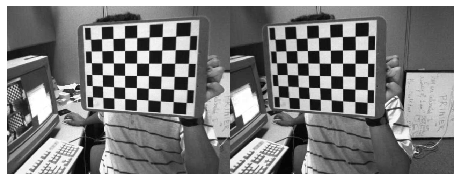

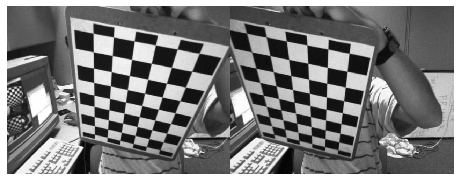

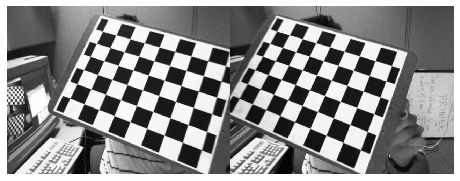

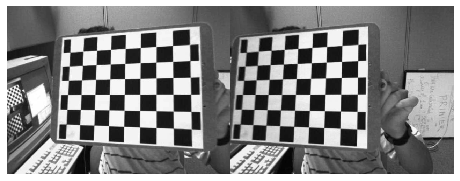

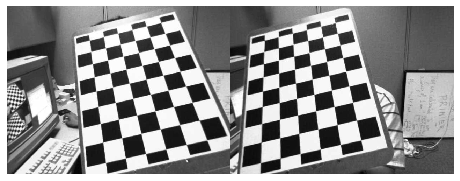

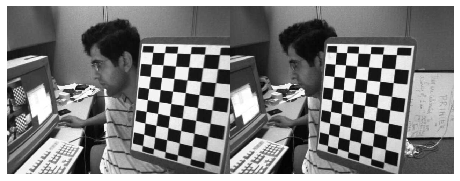

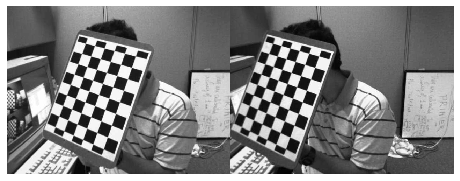

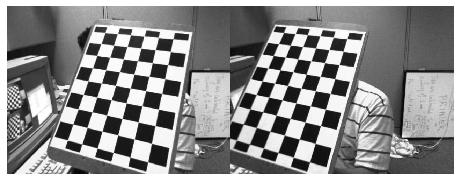

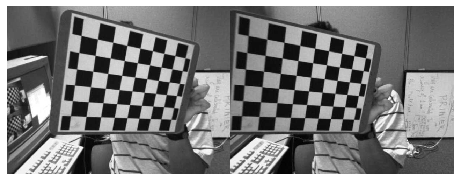

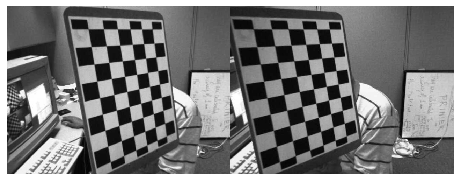

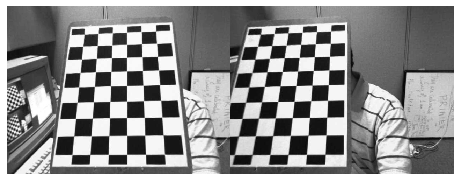

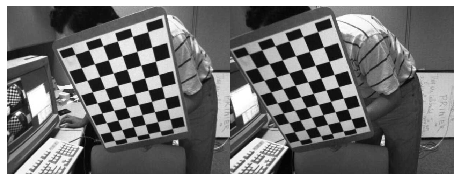

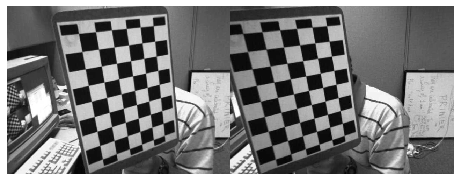

In [11]:
images1_rect, images2_rect, maps1, maps2 = cbcalib.undistort_and_rectify_images_stereo(
    images1,
    images2,
    runner['cm_1'],
    runner['dc_1'],
    runner['cm_2'],
    runner['dc_2'],
    runner['R1'],
    runner['R2'],
    runner['P1'],
    runner['P2']
)

for i in range(len(images1_rect)):
    plt.figure(figsize=(8, 4))
    plt.imshow(np.hstack((images1_rect[i], images2_rect[i])), cmap='gray')
    plt.axis('off')

## Triangulation

In [12]:
def cb_row_by_row(pattern_size):
    """
    Generator of pairs of (start, end)
    indices of a chessboard pattern 
    per each row. 
    """

    n_cols, n_rows = pattern_size

    idx = 0

    for i in range(n_rows):
        start = i * n_cols
        end = start + n_cols
        yield start, end


def measure_cb_distances_in_rows(points_3d, pattern_size):

    distances = []

    n_cols, n_rows = pattern_size
    assert len(points_3d) == (n_cols * n_rows)

    for start, end in cb_row_by_row(pattern_size):

        row_points = points_3d[start:end]

        for i in range(len(row_points) - 1):
            p1 = row_points[i]
            p2 = row_points[i + 1]
            dist = np.linalg.norm(p1 - p2)
            distances.append(dist)

    return np.array(distances)

## Triangulation given the original image points

In [13]:
point_clouds = cbcalib.triangulate_impoints(
    runner['P1'], 
    runner['P2'], 
    runner['image_points_1'], 
    runner['image_points_2']
)

# each row per image pair
distances = np.array([measure_cb_distances_in_rows(pcloud, psize) for pcloud in point_clouds])

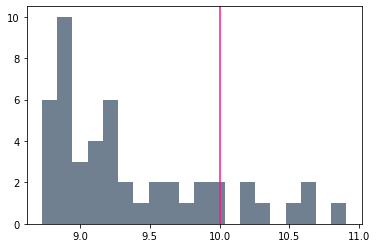

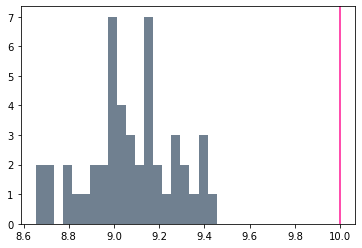

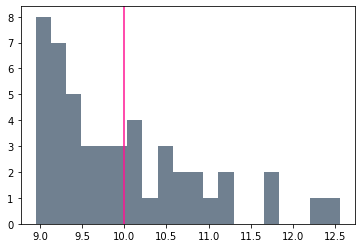

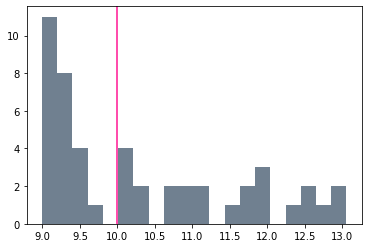

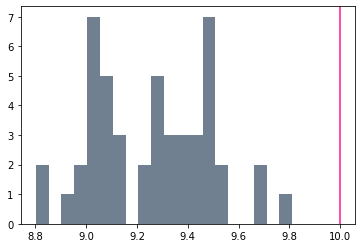

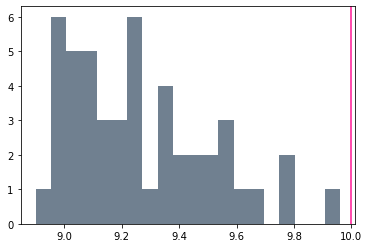

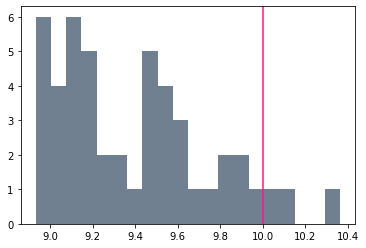

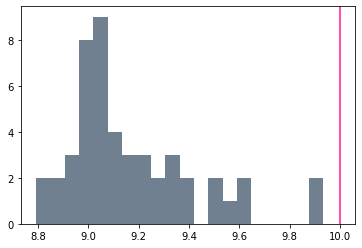

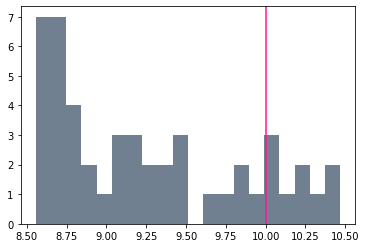

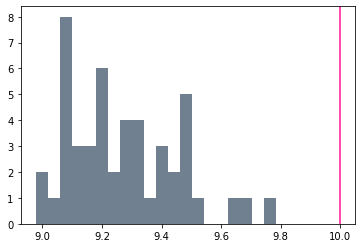

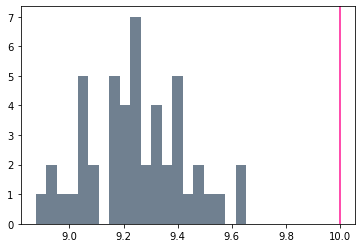

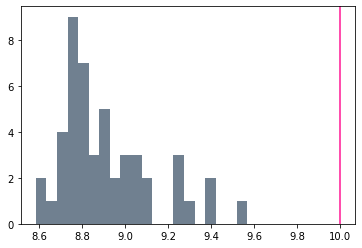

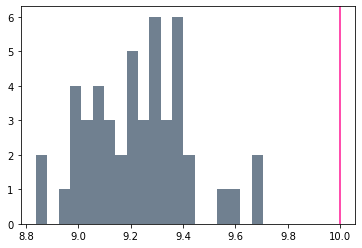

In [14]:
for d in distances:
    
    plt.figure()
    plt.hist(d, bins=20, color='slategrey')
    plt.axvline(sq_size, color='deeppink')

## Undistortion

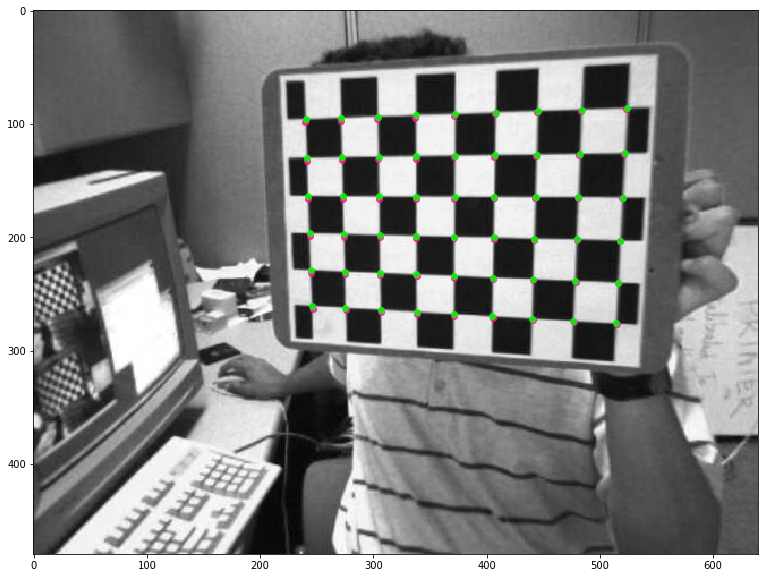

In [15]:
up_p = cbcalib.undistort_points(runner['image_points_1'][0], runner['cm_1'], runner['dc_1'], runner['P1'])
up_pr = cbcalib.undistort_points(runner['image_points_1'][0], runner['cm_1'], runner['dc_1'], runner['P1'], runner['R1'])

plt.figure(figsize=(15, 10))
_ = plt.imshow(images1_rect[0], cmap='gray')
_ = plt.scatter(up_p[:, 0], up_p[:, 1], color='deeppink', alpha=0.8)
_ = plt.scatter(up_pr[:, 0], up_pr[:, 1], color='lime', alpha=0.8)

## Triangulation with undistorted image points

In [16]:
def undist_1(image_points):
    return cbcalib.undistort_points(image_points, runner['cm_1'], runner['dc_1'], runner['P1'], runner['R1'])

def undist_2(image_points):
    return cbcalib.undistort_points(image_points, runner['cm_2'], runner['dc_2'], runner['P2'], runner['R2'])


point_clouds_ud = cbcalib.triangulate_impoints(
    runner['P1'], 
    runner['P2'], 
    [undist_1(imp) for imp in runner['image_points_1']],
    [undist_2(imp) for imp in runner['image_points_2']]
)

# each row per image pair
distances_ud = np.array([measure_cb_distances_in_rows(pcloud, psize) for pcloud in point_clouds_ud])

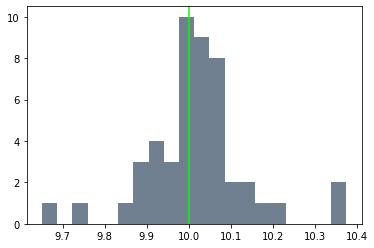

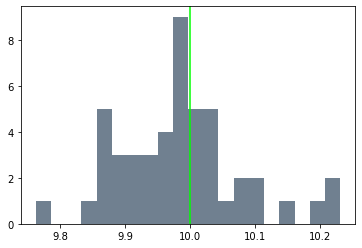

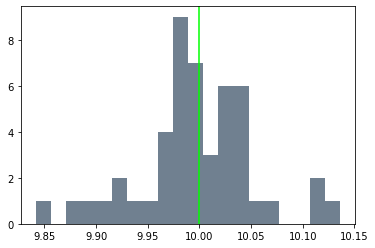

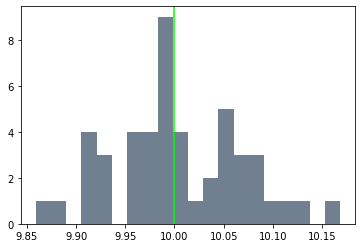

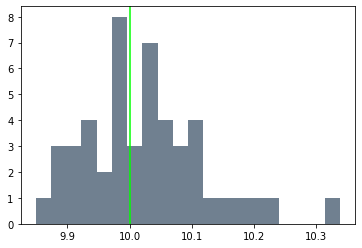

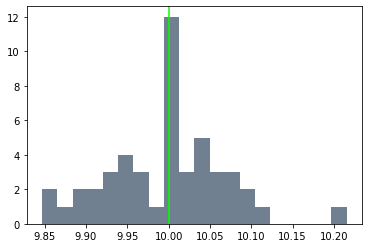

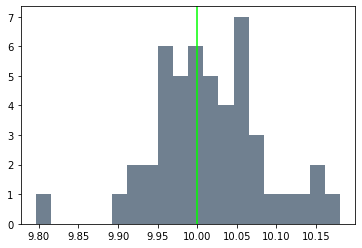

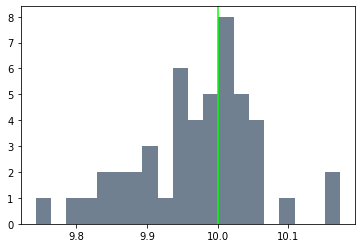

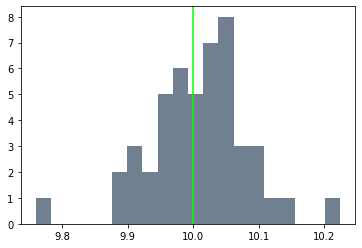

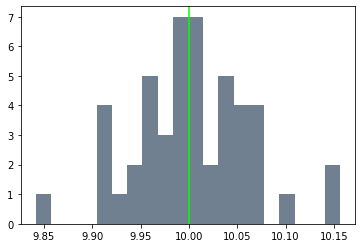

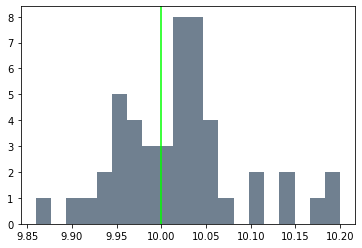

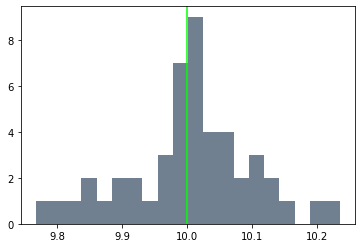

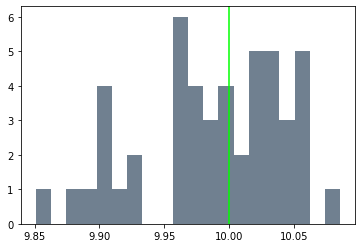

In [17]:
for d in distances_ud:
    
    plt.figure()
    plt.hist(d, bins=20, color='slategrey')
    plt.axvline(sq_size, color='lime')

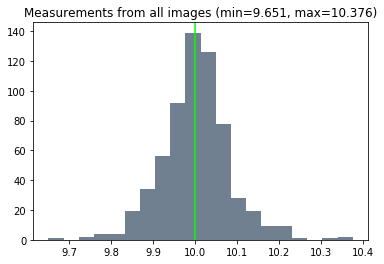

In [18]:
_ = plt.hist(distances_ud.ravel(), bins=20, color='slategrey')
_ = plt.axvline(sq_size, color='lime')
_ = plt.title('Measurements from all images (min={:.3f}, max={:.3f})'.format(distances_ud.min(), distances_ud.max()))